
# Thyroid Recurrence — Least Squares vs Linear SVM (No-Warnings Edition)

Same methodology you requested:
- **Least Squares** (LinearRegression + 0.5 threshold) vs **Linear SVM**
- **Inner 5-fold CV** on the **training split** to tune SVM **C**
- **Final 5-fold CV** to average performance of **finalized** models

Extra steps to eliminate warnings:
- Robust preprocessing (impute → scale/OHE → clean)
- Global suppression of NumPy floating warnings
- Safe prediction & custom scorer that clamp/clean predictions before thresholding


In [1]:

# Imports & global suppression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import matplotlib.pyplot as plt
import warnings, numpy as np
np.seterr(all="ignore")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix,accuracy_score


In [2]:

# Load & inspect
df = pd.read_csv("Thyroid_Diff.csv")
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
print("Shape:", df.shape)
display(df.head())
print("\nDtypes:\n", df.dtypes)
print("\nTarget counts:\n", df["Recurred"].value_counts(dropna=False))
print("\n\n\n",df.isna().sum())

Shape: (383, 17)


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No



Dtypes:
 Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

Target counts:
 Recurred
No     275
Yes    108
Name: count, dtype: int64



 Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage  

In [3]:

# Schema & split
target_col = "Recurred"
numeric_cols = ["Age"]
cat_cols = [c for c in df.columns if c not in [target_col] + numeric_cols]

X_raw = df.drop(columns=[target_col])
y = df[target_col].replace({"Yes": 1, "No": 0}).astype("Int64")
mask = y.notna()
X_raw, y = X_raw.loc[mask].copy(), y.loc[mask].astype(int).to_numpy().ravel()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

X_train_raw.shape, X_test_raw.shape


((306, 16), (77, 16))

In [4]:


num_clip = FunctionTransformer(lambda X: np.clip(X, -10.0, 10.0), feature_names_out="one-to-one")
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True)),
    ("clip", num_clip),
])

try:
    ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
    ("vt", VarianceThreshold(threshold=0.0)),
])

pre_base = ColumnTransformer(
    transformers=[("num", num_pipe, numeric_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop",
)

def _final_clean(X):
    X = np.asarray(X, dtype=np.float64)
    return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

clean = FunctionTransformer(_final_clean, feature_names_out="one-to-one")

preprocessor = Pipeline(steps=[("pre_base", pre_base), ("clean", clean)])


In [5]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    _ = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["No","Yes"]); ax.set_yticklabels(["No","Yes"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

def safe_threshold_preds(estimator, X, thr=0.5):
    # Clean predictions to avoid overflow/NaN warnings
    y_cont = estimator.predict(X)
    y_cont = np.nan_to_num(y_cont, nan=0.0, posinf=0.0, neginf=0.0)
    y_cont = np.clip(y_cont, -1e6, 1e6)
    return (y_cont >= thr).astype(int)

# Custom scorer for LS that cleans preds before thresholding
def ls_bal_acc_scorer(estimator, X, y_true):
    y_pred = safe_threshold_preds(estimator, X, 0.5)
    return balanced_accuracy_score(y_true, y_pred)


Least Squares — Balanced accuracy (holdout): 0.932

Least Squares — Classification report:
               precision    recall  f1-score   support

          No       0.95      1.00      0.97        55
         Yes       1.00      0.86      0.93        22

    accuracy                           0.96        77
   macro avg       0.97      0.93      0.95        77
weighted avg       0.96      0.96      0.96        77



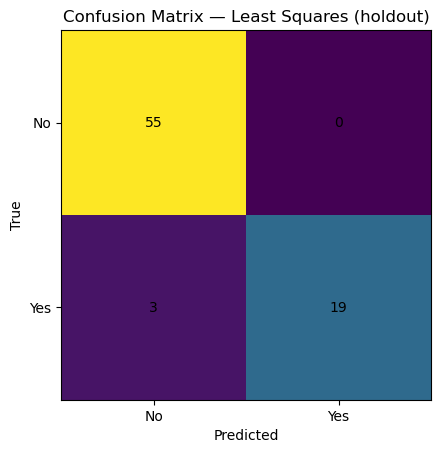

In [6]:

# Least Squares: fit & holdout (no warnings)
pipe_ls = Pipeline(steps=[("prep", preprocessor), ("model", LinearRegression())])
pipe_ls.fit(X_train_raw, y_train)

y_test_pred_ls = safe_threshold_preds(pipe_ls, X_test_raw, 0.5)
print("Least Squares — Balanced accuracy (holdout):", f"{balanced_accuracy_score(y_test, y_test_pred_ls):.3f}")
print("\nLeast Squares — Classification report:\n", classification_report(y_test, y_test_pred_ls, target_names=["No","Yes"]))
plot_cm(y_test, y_test_pred_ls, "Confusion Matrix — Least Squares (holdout)")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C (inner CV): 0.1  | Best CV bal acc: 0.946
Linear SVM (tuned) — Balanced accuracy (holdout): 0.955
              precision    recall  f1-score   support

          No       0.96      1.00      0.98        55
         Yes       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77



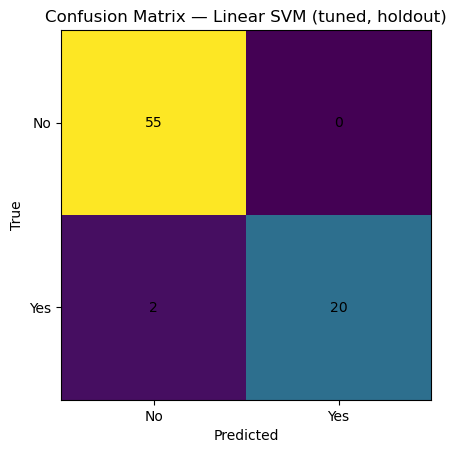

In [7]:

# SVM: inner CV tuning + holdout (no warnings expected)
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_svm_base = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearSVC(class_weight="balanced", dual="auto", max_iter=20000, random_state=42)),
])

svm_param_grid = {"model__C": [0.01, 0.1, 1, 10, 100]}

svm_grid = GridSearchCV(
    estimator=pipe_svm_base,
    param_grid=svm_param_grid,
    scoring="balanced_accuracy",
    cv=cv_inner,
    n_jobs=-1,
    refit=True,
    verbose=1
)
svm_grid.fit(X_train_raw, y_train)

best_C = svm_grid.best_params_["model__C"]
print("Best C (inner CV):", best_C, " | Best CV bal acc:", f"{svm_grid.best_score_:.3f}")

y_test_pred_svm = svm_grid.predict(X_test_raw)


print("Linear SVM (tuned) — Balanced accuracy (holdout):", f"{balanced_accuracy_score(y_test, y_test_pred_svm):.3f}")
print(classification_report(y_test, y_test_pred_svm, target_names=["No", "Yes"]))

plot_cm(y_test, y_test_pred_svm, "Confusion Matrix — Linear SVM (tuned, holdout)")


In [8]:

# Final 5-fold outer CV (no warnings): averaged performance for report
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

cv_ls = cross_val_score(pipe_ls, X_raw, y, scoring=ls_bal_acc_scorer, cv=cv_outer, n_jobs=-1)
print("FINAL 5-FOLD CV — Least Squares:", f"{cv_ls.mean():.3f} ± {cv_ls.std():.3f}")

pipe_svm_final = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearSVC(C=best_C, class_weight="balanced", dual="auto", max_iter=20000, random_state=42)),
])
cv_svm = cross_val_score(pipe_svm_final, X_raw, y, scoring="balanced_accuracy", cv=cv_outer, n_jobs=-1)
print("FINAL 5-FOLD CV — Linear SVM   :", f"{cv_svm.mean():.3f} ± {cv_svm.std():.3f}")


FINAL 5-FOLD CV — Least Squares: 0.925 ± 0.034
FINAL 5-FOLD CV — Linear SVM   : 0.945 ± 0.024
